# Business Problem
### This project determines which tweets can be correctly identified to contain  either positive sentiments (“Positive emotion”) or negative sentiments(“Negative emotion”) using a binary classifier. 


In [5]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.patches as mpatches


import string

from nltk.corpus import stopwords
stop = stopwords.words('english')

from helper import model_helper, word_count_by_class, tweet_finder_by_word

# 1. Obtain

In [6]:
# load in the dataset
df = pd.read_csv("data/emoting_tweets.csv", encoding_errors="ignore")
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# 2. Scrub + Explore

In [7]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9063,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [8]:
df.shape

(9093, 3)

In [9]:
# rename target column
df["target"] = df["is_there_an_emotion_directed_at_a_brand_or_product"]

In [10]:
# drop former target column to clean up dataset
df.drop(columns=["is_there_an_emotion_directed_at_a_brand_or_product"], inplace=True)

In [11]:
# view target column distribution 
df["target"].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: target, dtype: float64

In [12]:
# drop two unnecessary target variables
df = df[(df["target"] != "No emotion toward brand or product") & (df["target"] != "I can't tell")]

In [13]:
# view target column distribution
df["target"].value_counts(normalize=True)

Positive emotion    0.839346
Negative emotion    0.160654
Name: target, dtype: float64

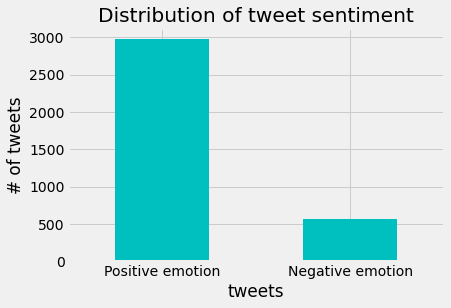

In [14]:
# View distribution of the target values
with plt.style.context('fivethirtyeight'):
    df['target'].value_counts().plot(kind='bar', color = "c")

    # giving title to the plot
    plt.title("Distribution of tweet sentiment")

    # giving X and Y labels
    plt.xlabel("tweets")
    plt.xticks(rotation = 0)
    plt.ylabel("# of tweets")

    plt.show()

In [15]:
# view target column counts
df["target"].value_counts()

Positive emotion    2978
Negative emotion     570
Name: target, dtype: int64

In [16]:
# change "Positive emotion" to equal 1 and "Negative emotion" to equal 0
df["target"] = np.where(df['target'] == "Positive emotion", 1, 0)

In [17]:
# confirm change
df["target"].value_counts()

1    2978
0     570
Name: target, dtype: int64

In [18]:
# set text to lowercase
df['tweet_lowercase'] = df['tweet_text'].map(lambda x: str(x).lower())
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...


In [19]:
# remove punctuation
no_punctuation = []
for s in df['tweet_lowercase']:
    for p in string.punctuation:
        s = s.replace(p, '')
    no_punctuation.append(s)

In [20]:
# add no_punction column to the dataframe
df['no_punctuation'] = no_punctuation

In [21]:
# view dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...


In [22]:
# remove stop words
df['tweets_without_stopwords'] = df['no_punctuation'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [23]:
# view dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,target,tweet_lowercase,no_punctuation,tweets_without_stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 3g iphone 3 hrs tweeting riseaustin d...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,@jessedee know about @fludapp ? awesome ipad/i...,jessedee know about fludapp awesome ipadiphon...,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,@swonderlin can not wait for #ipad 2 also. the...,swonderlin can not wait for ipad 2 also they s...,swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,@sxsw i hope this year's festival isn't as cra...,sxsw i hope this years festival isnt as crashy...,sxsw hope years festival isnt crashy years iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,@sxtxstate great stuff on fri #sxsw: marissa m...,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff fri sxsw marissa mayer g...


In [24]:
# view count of most common words within tweets_without_stopwords
df['tweets_without_stopwords'].str.split(expand=True).stack().value_counts()

sxsw             3655
mention          2482
link             1310
ipad             1164
rt               1059
                 ... 
ahh                 1
wonderful           1
experimenting       1
tinkering           1
stabilizer          1
Length: 6448, dtype: int64

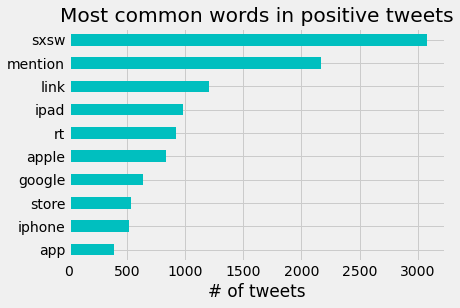

In [25]:
# graph of top 10 words of positive tweets
with plt.style.context('fivethirtyeight'):
    pd.DataFrame(df[df['target'] == 1]['tweets_without_stopwords'].str.split(
            expand=True).stack().value_counts().head(11)).drop("2").plot(kind="barh", color="c", legend=False)
    plt.gca().invert_yaxis()
    plt.xlabel("# of tweets")
    plt.title("Most common words in positive tweets")

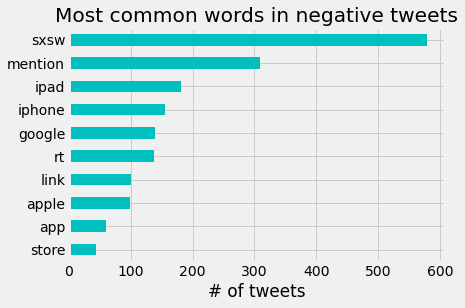

In [26]:
# graph of top 10 words of negative tweets
with plt.style.context('fivethirtyeight'):
    pd.DataFrame(df[df['target'] == 0]['tweets_without_stopwords'].str.split(
            expand=True).stack().value_counts().head(11)).drop("2").plot(kind="barh", color="c", legend=False)
    plt.gca().invert_yaxis()
    plt.xlabel("# of tweets")
    plt.title("Most common words in negative tweets")

# 4. Model

#### Train test split

In [27]:
# train test split 
X = df['tweets_without_stopwords']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

## Bag of words model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [28]:
lr_basic = model_helper(X, y, LogisticRegression(), bow=True)

Training Score: 0.9857349596857556
Testing Score: 0.9342948717948717


In [29]:
dt_basic = model_helper(X, y, DecisionTreeClassifier(), bow=True)

Training Score: 0.9997904881625812
Testing Score: 0.9211822660098522


In [30]:
dt_70 = model_helper(X, y, DecisionTreeClassifier(max_depth=70), bow=True)

Training Score: 0.9861598843214212
Testing Score: 0.9193154034229829


### * Best model score 🎉

In [31]:
rf = model_helper(X, y, RandomForestClassifier(), bow=True)

Training Score: 0.9997905759162303
Testing Score: 0.9319620253164556


In [32]:
rf_50 = model_helper(X, y, RandomForestClassifier(max_depth=50), bow=True)

Training Score: 0.937365010799136
Testing Score: 0.9177018633540373


## Bag of words with class_weight="balanced" model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [33]:
lr_cw = model_helper(X, y, LogisticRegression(class_weight="balanced"), bow=True)

Training Score: 0.9902789518174133
Testing Score: 0.9226890756302522


In [34]:
dt_cw = model_helper(X, y, DecisionTreeClassifier(class_weight="balanced"), bow=True)

Training Score: 0.9997904881625812
Testing Score: 0.8873362445414847


In [35]:
rf_cw = model_helper(X, y, RandomForestClassifier(class_weight="balanced"), bow=True)

Training Score: 0.9997904881625812
Testing Score: 0.9304897314375987


## Tfidf model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [36]:
lr_tfidf = model_helper(X, y, LogisticRegression(), bow=False)

Training Score: 0.922660479505027
Testing Score: 0.91415313225058


In [37]:
dt_tfidf = model_helper(X, y, DecisionTreeClassifier(), bow=False)

Training Score: 0.9997904881625812
Testing Score: 0.9042904290429042


In [38]:
rf_tfidf = model_helper(X, y, RandomForestClassifier(), bow=False)

Training Score: 0.9997905759162303
Testing Score: 0.9268292682926829


## Tfidf and class_weight="balanced" model iteration
### Use logistic regression, decision tree classifier, and random forest classifier

In [39]:
lr_tfidf = model_helper(X, y, LogisticRegression(class_weight="balanced"), bow=False)

Training Score: 0.9650259067357513
Testing Score: 0.9100257069408739


In [40]:
dt_tfidf = model_helper(X, y, DecisionTreeClassifier(class_weight="balanced"), bow=False)

Training Score: 0.9997904881625812
Testing Score: 0.8588640275387264


In [41]:
rf_tfidf = model_helper(X, y, RandomForestClassifier(class_weight="balanced"), bow=False)

Training Score: 0.9997904881625812
Testing Score: 0.9222309505106049


# 5. Interpret

In [42]:
# Make confusion matrix
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

C:\Users\Jeff\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


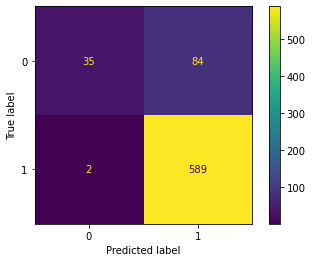

In [43]:
# confusion matrix with best model, random forest
plot_confusion_matrix(rf, X_test_bow, y_test)

In [44]:
# make feature importance plot
feat_importance = pd.DataFrame({"word": vectorizer.get_feature_names_out(), 
                               "importance": rf.feature_importances_})

In [45]:
# view feature importance
fi = feat_importance.sort_values(by="importance", ascending=False).head(10)
fi

,word,importance
2898,link,0.014342
3121,mention,0.009525
1761,fail,0.009000
2270,headaches,0.008466
1460,doesnt,0.006072
2259,hate,0.006034
2618,iphone,0.005980
1785,fascist,0.005494
3213,money,0.005487
4249,rt,0.005324


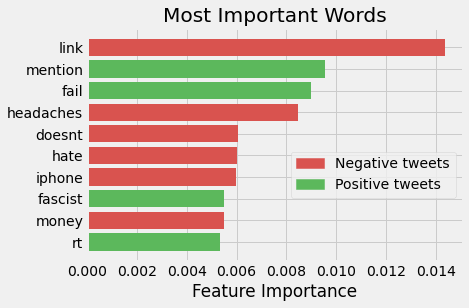

In [46]:
# graph of most important words with the above feature importance plot
with plt.style.context('fivethirtyeight'):
    plt.barh(y=fi["word"], width=fi["importance"], color=['#d9534f', '#5cb85c','#5cb85c','#d9534f', '#d9534f',
                                                          '#d9534f', '#d9534f', '#5cb85c', '#d9534f',  '#5cb85c' ])
    plt.gca().invert_yaxis()
    
    red_patch = mpatches.Patch(color= '#d9534f', label='Negative tweets')
    green_patch = mpatches.Patch(color= '#5cb85c', label='Positive tweets')

    plt.legend(handles=[red_patch, green_patch], bbox_to_anchor=(1, 0.5))
    plt.xlabel('Feature Importance')
    plt.title('Most Important Words');

In [47]:
# look at target count by keyword function
word_count_by_class("link", df)

postive count: 1209
negative count: 101


In [48]:
# find tweets by keyword function
tweet_finder_by_word("fail", df)

positive - Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail
positive - I love my @mention iPhone case from #Sxsw but I can't get my phone out of it #fail
positive - How could I forget my cell phone today for #SXSW what a fail glad I have my iPad #lifelinetotheworld
negative - So we get to see google fail at social on another day RT @mention Okay, no Google Circles debuting at #sxsw today
negative - @mention @mention @mention @mention Paper phones?  Means an iPad will likely be useless at #sxsw as well. #fail
negative - 2+ hour wait at the makeshift Apple store for iPad 2. #fail #sxsw
negative - @mention another google social failure? #sxsw
negative - Stupid technology! You always fail at important times! At #SXSW w/ an iPhone, laptop AND Blackberry and the only thing working is my pen.
positive - Fail Whale artist @mention living through the iPad 2 #sxsw {link}
negative - #sxsw live stream not working on iPad #fail {

# Conclusions and Future Work

### Using a machine learning, we can predict whether a tweet is positive. Negative tweets have strongly negative words while positive tweets have less distinctive words that indicate positivity. For future work, I’d look at the labels of the tweets. There are some tweets that appeared to be incorrectly labeled within the dataset.
